# Making Figure 6 of paper
23/03/2025

In [24]:
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import json

plt.rcParams.update({'font.size': 16})
import seaborn as sns
import os
from bagpipes import plotting
pipes.plotting.update_rcParams()
matplotlib.rcParams["axes.linewidth"] = 1.0

# adds in additional chemical evolution models to bagpipes
from code_bits.add_ceh_funcs import *
# adds in VW07 dust to bagpipes
from code_bits.add_VW07_dust import *
# import a bunch of useful functions for interfacing with bagpipes
from code_bits import fitting_MaNGA
# adds in additional GP noise kernels to bagpipes
from code_bits.add_GP_SHOTerm import *

In [7]:
# change working directory to one layer above
os.chdir('..')
# set saving direction
save_dir = 'plots/'
# directory of the skyline file
skyline_dir = 'data'
# plateifu list of galaxies plotted
plateifu_list = ['8997-3704', '7990-12705', '8324-12701', '8713-3703', '8440-1901', '8651-1902', '8152-3703', '10498-6101']
RPSB_type = [1,2,2,2,3,3,4,4]

# bagpipes runID, used to find the right folder that holds the posterior samples file
# here we specify the suffix that comes after the plateifu
runID_suffix_PSB = '_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step'
runID_suffix_central = '_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM'
# file name of the posterior samples file
galID_suffix_PSB = '_PSBonly_dereddened_051022'
galID_suffix_central = '_RPSB_centralspx_dereddened_170624'

In [3]:
"""
since the PSB regions' bagpipes fits were ran in an older version of bagpipes, we need
to swap out some parts of bagpipes code on the fly
"""

import deepdish as dd
from copy import deepcopy
import h5py
from bagpipes.fitting import fitted_model,posterior
rank = 0

def fit_init_PSB(self, galaxy, fit_instructions, run=".", time_calls=False,
             n_posterior=500):

    self.run = run
    self.galaxy = galaxy
    self.fit_instructions = deepcopy(fit_instructions)

    # Set up the directory structure for saving outputs.
    if rank == 0:
        utils.make_dirs(run=run)

    # The base name for output files.
    self.fname = "pipes/posterior/" + run + "/" + self.galaxy.ID + "_"

    # A dictionary containing properties of the model to be saved.
    self.results = {"fit_instructions": self.fit_instructions}

    # If a posterior file already exists load it.
    if os.path.exists(self.fname[:-1] + ".h5"):
        self.results = dd.io.load(self.fname[:-1] + ".h5")
        self.posterior = posterior(self.galaxy, run=run,
                                   n_samples=n_posterior)
        self.fit_instructions = dd.io.load(self.fname[:-1] + ".h5",
                                           group="/fit_instructions")
        if 'psb2' in self.fit_instructions.keys():
            self.fit_instructions['psb_wild2020'] = self.fit_instructions.pop('psb2')

        if rank == 0:
            print("\nResults loaded from " + self.fname[:-1] + ".h5\n")

    # Set up the model which is to be fitted to the data.
    self.fitted_model = fitted_model(galaxy, self.fit_instructions,
                                     time_calls=time_calls)
    
def fit_init_central(self, galaxy, fit_instructions, run=".", time_calls=False,
             n_posterior=500):

    self.run = run
    self.galaxy = galaxy
    self.fit_instructions = deepcopy(fit_instructions)
    self.n_posterior = n_posterior

    # Set up the directory structure for saving outputs.
    if rank == 0:
        utils.make_dirs(run=run)

    # The base name for output files.
    self.fname = "pipes/posterior/" + run + "/" + self.galaxy.ID + "_"

    # A dictionary containing properties of the model to be saved.
    self.results = {}

    # If a posterior file already exists load it.
    if os.path.exists(self.fname[:-1] + ".h5"):
        file = h5py.File(self.fname[:-1] + ".h5", "r")

        self.posterior = posterior(self.galaxy, run=run,
                                   n_samples=n_posterior)

        fit_info_str = file.attrs["fit_instructions"]
        fit_info_str = fit_info_str.replace("array", "np.array")
        fit_info_str = fit_info_str.replace("float", "np.float")
        self.fit_instructions = eval(fit_info_str)

        for k in file.keys():
            self.results[k] = np.array(file[k])
            if np.sum(self.results[k].shape) == 1:
                self.results[k] = self.results[k][0]

        if rank == 0:
            print("\nResults loaded from " + self.fname[:-1] + ".h5\n")

    # Set up the model which is to be fitted to the data.
    self.fitted_model = fitted_model(galaxy, self.fit_instructions,
                                     time_calls=time_calls)

def posterior_init_PSB(self, galaxy, run=".", n_samples=500):
    self.galaxy = galaxy
    self.run = run
    self.n_samples = n_samples

    fname = "pipes/posterior/" + self.run + "/" + self.galaxy.ID + ".h5"

    # Check to see whether the object has been fitted.
    if not os.path.exists(fname):
        raise IOError("Fit results not found for " + self.galaxy.ID + ".")

    # Reconstruct the fitted model.
    self.fit_instructions = dd.io.load(fname, group="/fit_instructions")
    if 'psb2' in self.fit_instructions.keys():
        self.fit_instructions['psb_wild2020'] = self.fit_instructions.pop('psb2')
    self.fitted_model = fitted_model(self.galaxy, self.fit_instructions)

    # 2D array of samples for the fitted parameters only.
    self.samples2d = dd.io.load(fname, group="/samples2d")

    # If fewer than n_samples exist in posterior, reduce n_samples
    if self.samples2d.shape[0] < self.n_samples:
        self.n_samples = self.samples2d.shape[0]

    # Randomly choose points to generate posterior quantities
    self.indices = np.random.choice(self.samples2d.shape[0],
                                    size=self.n_samples, replace=False)

    self.samples = {}  # Store all posterior samples

    dirichlet_comps = []  # Do any parameters follow Dirichlet dist

    # Add 1D posteriors for fitted params to the samples dictionary
    for i in range(self.fitted_model.ndim):
        param_name = self.fitted_model.params[i]

        if "dirichlet" in param_name:
            dirichlet_comps.append(param_name.split(":")[0])

        self.samples[param_name] = self.samples2d[self.indices, i]

    self.get_dirichlet_tx(dirichlet_comps)

    self.get_basic_quantities()
    
def posterior_init_central(self, galaxy, run=".", n_samples=500):
    self.galaxy = galaxy
    self.run = run
    self.n_samples = n_samples

    fname = "pipes/posterior/" + self.run + "/" + self.galaxy.ID + ".h5"

    # Check to see whether the object has been fitted.
    if not os.path.exists(fname):
        raise IOError("Fit results not found for " + self.galaxy.ID + ".")

    # Reconstruct the fitted model.
    file = h5py.File(fname, "r")

    fit_info_str = file.attrs["fit_instructions"]
    fit_info_str = fit_info_str.replace("array", "np.array")
    fit_info_str = fit_info_str.replace("float", "np.float")
    self.fit_instructions = eval(fit_info_str)

    self.fitted_model = fitted_model(self.galaxy, self.fit_instructions)

    # 2D array of samples for the fitted parameters only.
    self.samples2d = np.array(file["samples2d"])

    # If fewer than n_samples exist in posterior, reduce n_samples
    if self.samples2d.shape[0] < self.n_samples:
        self.n_samples = self.samples2d.shape[0]

    # Randomly choose points to generate posterior quantities
    self.indices = np.random.choice(self.samples2d.shape[0],
                                    size=self.n_samples, replace=False)

    self.samples = {}  # Store all posterior samples

    dirichlet_comps = []  # Do any parameters follow Dirichlet dist

    # Add 1D posteriors for fitted params to the samples dictionary
    for i in range(self.fitted_model.ndim):
        param_name = self.fitted_model.params[i]

        if "dirichlet" in param_name:
            dirichlet_comps.append(param_name.split(":")[0])

        self.samples[param_name] = self.samples2d[self.indices, i]

    self.get_dirichlet_tx(dirichlet_comps)

    self.get_basic_quantities()

In [20]:
# some functions to help retrieve the SFH from the posterior .h5 files

def add_ssfr(fit):
    sfh_ages = fit.posterior.sfh.ages*10**-9
    logage_lhs = pipes.utils.make_bins(np.log10(sfh_ages), make_rhs=True)[0]
    age_lhs = 10**(logage_lhs)
    age_lhs[0] = 0.
    hubble_time = pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    age_lhs[-1] = 10**9*hubble_time
    age_widths = age_lhs[1:] - age_lhs[:-1]

    nsamp = fit.posterior.n_samples
    ssfr = np.zeros((nsamp,len(sfh_ages)))
    for k in range(nsamp):
        ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
            np.flip(np.cumsum(np.flip(
                fit.posterior.samples["sfh"][k,:]*age_widths*10**9,0
            )),0)

    fit.posterior.samples["ssfr_history"] = ssfr

def load_PSB_sfh(PSB_runID, PSB_galID):

    # check if P32.1 is in folder posterior. If not, stick with P32
    temp_runID = PSB_runID.replace('P32','P32.1')
    if temp_runID in os.listdir('pipes/posterior'):
        PSB_runID = temp_runID

    # check if in file
    if PSB_runID in os.listdir('pipes/posterior'):
        # recover the fit's posterior and run params
        posterior_dir = 'pipes/posterior/'+PSB_runID
        json_file = PSB_galID+'.json'
        f = open(posterior_dir+'/'+json_file,'r')
        run_params = json.load(f)
        f.close()
        # change spectrum directory since this demonstration has a
        # slightly different file structure
        run_params['spectrum_dir'] = 'data/stacked_spectrum_PSB'

        pipes.config.R_spec = run_params['Rspec']

        fit_obj = fitting_MaNGA.fitting(skyline_dir, run_params=run_params, full=False)

        galaxy = pipes.galaxy(PSB_galID, fit_obj.load_manga_spec, photometry_exists=False)

        # swap out the init functiosn in bagpipes.fitting.fit and bagpipes.fitting.posterior because these .h5
        # files are saved using an older version of bagpipes
        pipes.fitting.fit.__init__ = fit_init_PSB
        pipes.fitting.posterior.__init__ = posterior_init_PSB
        fit = pipes.fit(galaxy, {}, run=run_params['runID'])

    add_ssfr(fit)
    PSB_ages = fit.posterior.sfh.ages/1e9
    PSB_sfh_percentiles = np.percentile(fit.posterior.samples['sfh'], (16,50,84), axis=0)
    PSB_logssfr_percentiles = np.percentile(np.log10(fit.posterior.samples['ssfr_history']), (16,50,84), axis=0)
    
    return PSB_ages, PSB_sfh_percentiles, PSB_logssfr_percentiles

def load_central_sfh(central_runID, central_galID):
    
    # check if in file
    if central_runID in os.listdir('pipes/posterior'):
        # recover the fit's posterior and run params
        posterior_dir = 'pipes/posterior/'+central_runID
        json_file = central_galID+'.json'
        f = open(posterior_dir+'/'+json_file,'r')
        run_params = json.load(f)
        f.close()
        # change spectrum directory since this demonstration has a
        # slightly different file structure
        run_params['spectrum_dir'] = 'data/stacked_spectrum_central'

        pipes.config.R_spec = run_params['Rspec']

        fit_obj = fitting_MaNGA.fitting(skyline_dir, run_params=run_params, full=False)

        galaxy = pipes.galaxy(central_galID, fit_obj.load_manga_spec, photometry_exists=False)

        # swap back the init function in bagpipes.fitting.fit and bagpipes.fitting.posterior to the new version
        pipes.fitting.fit.__init__ = fit_init_central
        pipes.fitting.posterior.__init__ = posterior_init_central
        fit = pipes.fit(galaxy, {}, run=run_params['runID'])
    
    add_ssfr(fit)
    central_ages = fit.posterior.sfh.ages/1e9
    central_sfh_percentiles = np.percentile(fit.posterior.samples['sfh'], (16,50,84), axis=0)
    central_logssfr_percentiles = np.percentile(np.log10(fit.posterior.samples['ssfr_history']), (16,50,84), axis=0)
    obs_z = np.median(fit.posterior.samples['redshift'])

    return central_ages, central_sfh_percentiles, central_logssfr_percentiles, obs_z

In [22]:
# calculate line in ssfr for constant SF
def constant_ssfr(sfh_ages, obs_z):
    logage_lhs = pipes.utils.make_bins(np.log10(sfh_ages), make_rhs=True)[0]
    age_lhs = 10**(logage_lhs)
    age_lhs[0] = 0.
    hubble_time = np.interp(obs_z, xp=pipes.utils.z_array, fp=pipes.utils.age_at_z)
    #hubble_time = pipes.utils.age_at_z[pipes.utils.z_array == 0.]
    sfh_hubble_time = hubble_time - sfh_ages
    return 1/sfh_hubble_time / 1e9

/opt/anaconda3/envs/bagpipes_1.0/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:317: RuntimeWarning: overflow encountered in power
  sfr_burst = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1
/opt/anaconda3/envs/bagpipes_1.0/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:322: RuntimeWarning: overflow encountered in power
  dpl_form = ((tburst/tau_plaw)**alpha + (tburst/tau_plaw)**-beta)**-1



Results loaded from pipes/posterior/8997-3704_PSBsummed_P32.1_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/8997-3704_PSBonly_dereddened_051022.h5


Results loaded from pipes/posterior/8997-3704_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM/8997-3704_RPSB_centralspx_dereddened_170624.h5



/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
/opt/anaconda3/envs/bagpipes_1.0/lib/python3.12/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this op


Results loaded from pipes/posterior/7990-12705_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/7990-12705_PSBonly_dereddened_051022.h5


Results loaded from pipes/posterior/7990-12705_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM/7990-12705_RPSB_centralspx_dereddened_170624.h5



/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ss


Results loaded from pipes/posterior/8324-12701_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/8324-12701_PSBonly_dereddened_051022.h5


Results loaded from pipes/posterior/8324-12701_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM/8324-12701_RPSB_centralspx_dereddened_170624.h5



/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ss


Results loaded from pipes/posterior/8713-3703_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/8713-3703_PSBonly_dereddened_051022.h5


Results loaded from pipes/posterior/8713-3703_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM/8713-3703_RPSB_centralspx_dereddened_170624.h5



/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ss


Results loaded from pipes/posterior/8440-1901_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/8440-1901_PSBonly_dereddened_051022.h5


Results loaded from pipes/posterior/8440-1901_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM/8440-1901_RPSB_centralspx_dereddened_170624.h5



/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ss


Results loaded from pipes/posterior/8651-1902_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/8651-1902_PSBonly_dereddened_051022.h5


Results loaded from pipes/posterior/8651-1902_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM/8651-1902_RPSB_centralspx_dereddened_170624.h5



/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ss


Results loaded from pipes/posterior/8152-3703_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/8152-3703_PSBonly_dereddened_051022.h5


Results loaded from pipes/posterior/8152-3703_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM/8152-3703_RPSB_centralspx_dereddened_170624.h5



/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ss


Results loaded from pipes/posterior/10498-6101_PSBsummed_P32.1_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step/10498-6101_PSBonly_dereddened_051022.h5


Results loaded from pipes/posterior/10498-6101_RPSB_centralspx_P14_dpl_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2c_nebularEM/10498-6101_RPSB_centralspx_dereddened_170624.h5



/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ssfr[k,:] = fit.posterior.samples["sfh"][k,:] / \
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  age_lhs[-1] = 10**9*hubble_time
/var/folders/9n/82gv6ltj69qcrbh6pcg8c_q80000gn/T/ipykernel_94504/2945864113.py:15: RuntimeWarning: invalid value encountered in divide
  ss

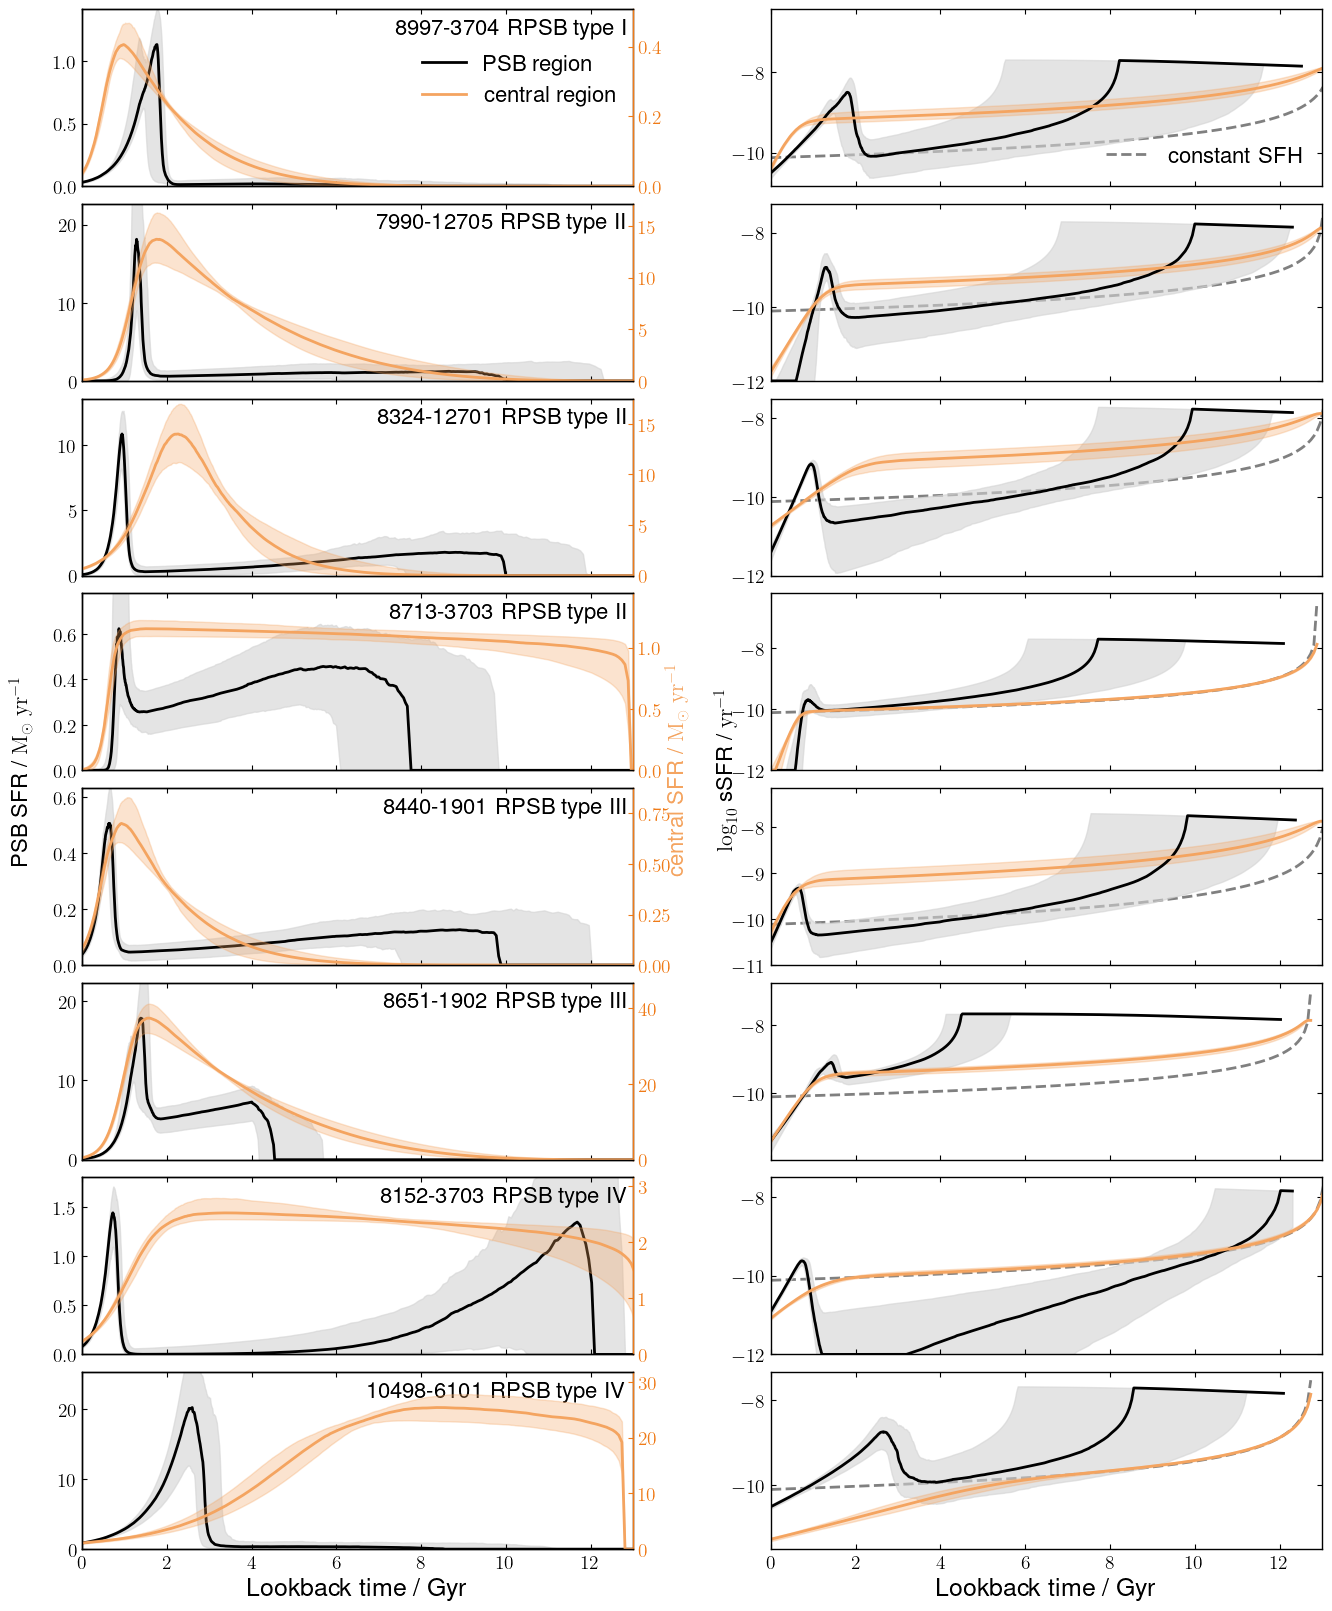

In [28]:
fig,axes = plt.subplots(len(plateifu_list), 2, figsize=[16,2.5*len(plateifu_list)], sharex=True)
plt.subplots_adjust(hspace=0.1, wspace=0.25)

for i,plateifu in enumerate(plateifu_list):
    [ax_sfh, ax_ssfr] = axes[i,:]
    
    # load in the RPSB region's SFH
    PSB_runID = plateifu + runID_suffix_PSB
    PSB_galID = plateifu + galID_suffix_PSB
    PSB_ages, PSB_sfh_percentiles, PSB_logssfr_percentiles = load_PSB_sfh(PSB_runID, PSB_galID)
    PSB_logssfr_percentiles[PSB_logssfr_percentiles<-12] = -12
    
    # load in the central region's SFH
    central_runID = plateifu + runID_suffix_central
    central_galID = plateifu + galID_suffix_central
    central_ages, central_sfh_percentiles, central_logssfr_percentiles, obs_z = load_central_sfh(central_runID, central_galID)
    central_logssfr_percentiles[central_logssfr_percentiles<-12] = -12
    
    # plot SFHs
    ax_sfh.plot(PSB_ages, PSB_sfh_percentiles[1], color='black')
    ax_sfh.fill_between(PSB_ages, PSB_sfh_percentiles[0], PSB_sfh_percentiles[2], color='lightgray', alpha=0.6, zorder=-1)
    ax_sfh2 = ax_sfh.twinx()
    ax_sfh2.plot(central_ages, central_sfh_percentiles[1], color='sandybrown')
    ax_sfh2.fill_between(central_ages, central_sfh_percentiles[0], central_sfh_percentiles[2], color='sandybrown', alpha=0.3, zorder=-1)

    # plot ssfr
    ax_ssfr.plot(PSB_ages, PSB_logssfr_percentiles[1], color='black')
    ax_ssfr.fill_between(PSB_ages, PSB_logssfr_percentiles[0], PSB_logssfr_percentiles[2], color='lightgray', alpha=0.6, zorder=-1)
    ax_ssfr.plot(central_ages, central_logssfr_percentiles[1], color='sandybrown')
    ax_ssfr.fill_between(central_ages, central_logssfr_percentiles[0], central_logssfr_percentiles[2], color='sandybrown', alpha=0.3, zorder=-1)
    
    # use constant ssfr as a comparison
    ssfr_ref = constant_ssfr(central_ages, obs_z)
    ax_ssfr.plot(central_ages, np.log10(ssfr_ref), color='gray', ls='--', zorder=-20, label='constant SFH')
    
    # set some y limits
    ax_sfh.set_ylim([0, max(PSB_sfh_percentiles[1])*1.25])
    ax_sfh2.set_ylim([0, max(central_sfh_percentiles[1])*1.25])
    if ax_ssfr.get_ylim()[0] < -12:
        ax_ssfr.set_ylim(bottom=-12)
        
    if i == 0:
        # make a legend
        legend_elements = [Line2D([0], [0], color='k', label='PSB region', lw=2),
                           Line2D([0], [0], color='sandybrown', label='central region', lw=2)]
        ax_sfh.legend(handles=legend_elements, loc=(0.6,0.4), frameon=False, fontsize=16)
        ax_ssfr.legend(loc='lower right', frameon=False, fontsize=16)
    
    # change the right axis of the first column into orange to indicate they are for the central regions
    ax_sfh2.yaxis.label.set_color('#ef7b18')
    ax_sfh2.tick_params(axis='y', colors='#ef7b18')
    ax_sfh2.spines['right'].set_color('#ef7b18')
    
    # add text for plateifu
    if RPSB_type[i] == 1:
        text_post = ' RPSB type I'
    elif RPSB_type[i] == 2:
        text_post = ' RPSB type II'
    elif RPSB_type[i] == 3:
        text_post = ' RPSB type III'
    elif RPSB_type[i] == 4:
        text_post = ' RPSB type IV'
    elif RPSB_type[i] == 0:
        text_post = ' RPSB type ambigious'
    ax_sfh.text(0.99, 0.95, plateifu+text_post, ha='right', va='top', color='k', transform=ax_sfh.transAxes, fontsize=16, zorder=20)
    
# labels and limits
axes[0,0].set_xlim([0, 13])
axes[-1,0].set_xlabel('Lookback time / Gyr')
axes[-1,1].set_xlabel('Lookback time / Gyr')
fig.text(0.08, 0.5, 'PSB SFR / $\\mathrm{M_\\odot\\;yr^{-1}}$', va='center', rotation='vertical', fontsize=16)
fig.text(0.49, 0.5, 'central SFR / $\\mathrm{M_\\odot\\;yr^{-1}}$', va='center', rotation='vertical', fontsize=16, color='sandybrown')
fig.text(0.52, 0.5, '$\\log_{10}$ sSFR / $\\mathrm{yr^{-1}}$', va='center', rotation='vertical', fontsize=16)
plt.show()

In [27]:
fig.savefig(save_dir+'RPSBvsCentral_sfh_h_noAGN.pdf', bbox_inches='tight', dpi=150)